# My First CountVectorizer

In [1]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Method to convert nltk PoS tags to WordNet PoS tags taken from here:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
                
    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]
    
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is', # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}

# Set list of "valid" tags such that when normalizing text, all words tagged with PoS = coordinating conjunction,
# cardinal digit, determiner, existential there, preposition/subordinating conjunction, list marker, predeterminer,
# possessive ending, personal pronoun, possessive pronoun, to, or interjection are dropped.
valid_tags_abbr = 'FJMNRVW'

In [3]:
class countvec:
    # initialize class & private variables
    def __init__(self, n = (1,1), remove_stopwords = False, normalize_text = True, lowercase = False):
        # INPUTS:
        # n: tuple with two elements (each = either 1, 2, or 3) expressing range of n-grams; default (1,1)
        # remove_stopwords: boolean determining whether stopwords should be removed; default False
        # normalize_text: boolean determining whether text should be normalized; default True
        
        if len(n) != 2:
            n = (1,1) # default unigrams only
            print("Please instantiate class countvec with tuple n having two elements. n has been reset to default value of (1,1).")
        else:
            if n[0] > n[1]:
                n = (n[1], n[0])
            if n[0] not in {1, 2, 3} or n[1] not in {1, 2, 3}:
                n = (1,1) # default unigrams only
                print("Please instantiate class countvec with tuple n having two elements = either 1, 2, or 3. n has been reset to default value of (1,1).")
        
        self.n = range(n[0], n[1]+1) # range of unigrams, bigrams, and/or trigrams
        self.stop = remove_stopwords # if True, then stopwords are removed
        self.normtext = normalize_text # if True, then punctuation is removed and text is lemmatized
        self.lowercase = lowercase # if True, then all words converted to lowercase
        self.corpus = None
        self.d = None
        self.terms = None
              
    # create a dictionary of terms which map to columns of the term-frequency matrix
    def fit(self, corpus):
        
        d = dict()
        k = 0
        self.corpus = corpus
            
        corp_words = []
        for text in self.corpus:
            words = word_tokenize(text)
            corp_words.append(words)
        
        # to normalize text (i.e. lowercase, remove punctuation, and lemmatize)
        if self.normtext:
            
            # iterate over words in texts in corpus
            # if PoS of word is in approved tags, keep; otherwise, remove word
            # if word is fewer than 2 characters, remove
            # lemmatize word
            # append words to new text words list
            # append text words list to new corpus words list
            # write over corp_words with new normalized corpus words list
            
            lemmatizer = WordNetLemmatizer()
            norm_corp_words = []
            
            for text_words in corp_words:
                norm_words = []
                for word in text_words:
                    PoS_tag = nltk.pos_tag([word])[0][1]
                    word = re.sub(r'[_-]', '', word)
                    
                    if word in contractions:
                        word = contractions[word]
                    
                    if (len(word) > 1) and (re.match(r'^\w+$', word)) and (PoS_tag[0].upper() in valid_tags_abbr):
                        if PoS_tag[0].upper() in 'JNVR':
                            lemma = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                        else:
                            lemma = lemmatizer.lemmatize(word)
                        
                        norm_words.append(lemma)
                
                norm_corp_words.append(norm_words)
                
            corp_words = norm_corp_words
        
        # to remove stopwords
        if self.stop:
            clean_corp_words = [] # initialize empty list of lists of words
            
            for text_words in corp_words: # iterate over lists of words in list of lists
                clean_words = [] # initialize empty list of words
                
                for word in text_words: # iterate over words in list of words
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                
                clean_corp_words.append(clean_words)
            
            corp_words = clean_corp_words
        
        if self.lowercase:
            lower_corp_words = []
            
            for text_words in corp_words:
                lower_words = []
                
                for word in text_words:
                    word = word.lower()
                    lower_words.append(word)
                
                lower_corp_words.append(lower_words)
            
            corp_words = lower_corp_words
        
        # create n-grams dictionary
        corp_ngrams = []
        for text_words in corp_words:
            n_grams = []
            for num in self.n:
                for i in range(len(text_words)-(num-1)):
                    ngram = text_words[i]
                    c = 1
                    while c < num:
                        ngram = ngram + '-' + text_words[i+c]
                        c += 1
                    n_grams.append(ngram)

                for n_gram in n_grams:
                    if n_gram not in d:
                        d[n_gram] = k
                        k += 1
                    
            corp_ngrams.append(n_grams)
        
        # write over self.corpus with "clean" version
        clean_corpus = []
        for text_tups in corp_words:
            words = [tup[0] for tup in text_tups]
            text = ' '.join(words)
            clean_corpus.append(text)
        self.corpus = clean_corpus
        
        self.d = d
        self.terms = corp_ngrams
        
    # create a term-frequency matrix of appropriate size (num_docs times vocab_size)
    def transform(self):
        
        # initialize term-frequency matrix
        tfMatrix = np.zeros((len(self.corpus),len(self.d)))
        
        # create n-grams from text
        for text in self.corpus:
            for ngram in self.terms[self.corpus.index(text)]:
                tfMatrix[self.corpus.index(text), self.d[ngram]] += 1
        
        return tfMatrix
    
    def get_vocab(self):
        # returns dictionary of terms
        
        # read about creating copies here:
        # https://thispointer.com/python-how-to-copy-a-dictionary-shallow-copy-vs-deep-copy/
        return self.d.copy()

In [4]:
articles = pd.read_table('./article_dataset.txt', header = None)
articles.columns = ['article']

In [5]:
articles.head()

,article
0,Barclays' defiance of US fines has merit Barcl...
1,How big is Hillary Clinton's lead in the presi...
2,Zika’s greatest ally is human intransigence Th...
3,Fight for the right: Cruz and Rubio spar in Ne...
4,Voting day: America finally goes the polls Can...


In [6]:
testcount = countvec(remove_stopwords = True, n = (1,2), lowercase = True)
testcount.fit(articles['article'][:50])
testcount.transform()

array([[11.,  1.,  7., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  1.,  1.,  1.]])

In [7]:
testcount.get_vocab()

{'barclays': 0,
 'defiance': 1,
 'us': 2,
 'fine': 3,
 'merit': 4,
 'disgrace': 5,
 'many': 6,
 'way': 7,
 'prefinancial': 8,
 'crisis': 9,
 'boom': 10,
 'year': 11,
 'tempt': 12,
 'think': 13,
 'bank': 14,
 'ask': 15,
 'department': 16,
 'justice': 17,
 'pay': 18,
 'large': 19,
 'bill': 20,
 'pollute': 21,
 'financial': 22,
 'system': 23,
 'mortgage': 24,
 'junk': 25,
 'cough': 26,
 'apologise': 27,
 'learn': 28,
 'humility': 29,
 'view': 30,
 'chief': 31,
 'executive': 32,
 'jes': 33,
 'staley': 34,
 'doj': 35,
 'claim': 36,
 'disconnect': 37,
 'fact': 38,
 'obligation': 39,
 'shareholder': 40,
 'customer': 41,
 'client': 42,
 'employee': 43,
 'defend': 44,
 'unreasonable': 45,
 'allegation': 46,
 'stance': 47,
 'possibly': 48,
 'foolhardy': 49,
 'go': 50,
 'open': 51,
 'legal': 52,
 'battle': 53,
 'powerful': 54,
 'prosecutor': 55,
 'risky': 56,
 'especially': 57,
 'end': 58,
 'lose': 59,
 'actually': 60,
 'grudge': 61,
 'respect': 62,
 'order': 63,
 'dish': 64,
 'errant': 65,
 'sin

# Latent Semantic Analysis (LSA)

In [8]:
class LSA:
    def __init__(self, A, k):
        self.A = A # term-frequency matrix
        self.k = min(k, A.shape[0], A.shape[1]) # number of topics
        if k > A.shape[0] or k > A.shape[1]:
            print('Number of topics, k, cannot be greater than number of documents, m, or number of terms, n. If input k out of range, k is reset to minimum of m or n.')
        self.u, self.s, self.vt = np.linalg.svd(A, full_matrices = True)
        self.uk = self.u[:,:self.k]
        self.vtk = self.vt[:self.k,:]
        self.sHat = self.s[:self.k]
    
    def transform(self):
        # yields topic distribution per document (m x k)
        # returns U matrix
        
        return self.uk.copy()
    
    def get_topics(self, n, term_dic):
        # return top n words for all k topics as a list of lists
        # returns V matrix as list of lists
        n = min(n, self.A.shape[1])
        if n > self.A.shape[1]:
            print('n cannot be larger than the total number of terms in the term-document matrix. If input value out of range, n reset to total number of terms.')
            
        # implement the n top words per topic part
        termindexlist = []
        # got idea for extracting indices of n top terms here:
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        #
        # read about converting numpy array to a list here:
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
        for i in range(self.vtk.shape[0]):
            arr = self.vtk[i,:].argsort()[-n:][::-1]
            termindexlist.append(arr.tolist())
        
        for indexList in termindexlist:
            for number in indexList:
                # found tips on how to extract dictionary key here:
                # https://www.geeksforgeeks.org/python-get-key-from-value-in-dictionary/
                indexList[indexList.index(number)] = list(term_dic.keys())[number]

        return termindexlist
    
    def get_importance(self):
        # return importance of all k topics as a list
        # returns S vector
        
        return self.sHat.tolist()

In [9]:
test_LSA = LSA(A = testcount.transform(), k = 10)

In [10]:
test_LSA.transform()

array([[-9.52421839e-03,  2.30161042e-02,  1.91621765e-02,
        -2.06741618e-02, -2.40452409e-02,  1.72652395e-02,
        -1.41569829e-04,  1.89890931e-02, -3.34316320e-02,
         6.03480059e-02],
       [-1.41564845e-02,  2.23538429e-03,  3.24010387e-02,
         2.05384327e-02, -4.35168259e-06,  3.48598687e-03,
         3.41303495e-03,  4.41184167e-02,  2.04354511e-02,
        -9.56053675e-03],
       [-4.41287912e-03,  8.73994939e-03,  9.40763630e-03,
         1.30385718e-03, -2.39683779e-02,  4.38533261e-03,
        -1.48821120e-02,  1.14029416e-02, -6.74473400e-03,
         1.13639204e-02],
       [-2.39423235e-02,  6.36263724e-02,  1.34949779e-01,
         1.16596906e-01,  4.21417691e-02, -1.51651859e-02,
         2.07259862e-02,  2.29531217e-01,  9.39216064e-02,
        -4.30716321e-03],
       [-3.56322550e-02,  4.61138209e-02,  1.08244066e-01,
         4.34822777e-02, -3.40456084e-02,  2.00824334e-02,
        -6.20524060e-03,  3.26550640e-01,  1.13063452e-01,
        -1.

In [11]:
test_LSA.get_topics(n = 6, term_dic = testcount.get_vocab())

[['psychfunk-shot',
  'abusive',
  'creepiness',
  'family-songs',
  'mothers-review',
  'review-modern'],
 ['say', 'eu', 'minister', 'would', 'new', 'prime'],
 ['trump', 'bank', 'new', 'clinton', 'woman', 'republican'],
 ['clinton', 'trump', 'campaign', 'woman', 'republican', 'cruz'],
 ['eu', 'vote', 'trump', 'referendum', 'italian', 'italy'],
 ['email', 'first', 'film', 'mail', 'release', 'message'],
 ['email', 'mail', 'pathology', 'service', 'message', 'user'],
 ['trump', 'donor', 'israel', 'proisrael', 'us', 'adelson'],
 ['film', 'trump', 'pathology', 'kiarostami', 'email', 'israel'],
 ['bank', 'customer', 'health', 'club', 'mental', 'fund']]

In [12]:
test_LSA.get_importance()

[365.711366267221,
 151.54887317185637,
 123.20341089454531,
 115.04192598460112,
 67.57103915203399,
 63.38073121460788,
 59.03696810774987,
 53.12247182202776,
 51.910216728821595,
 48.50219878107205]

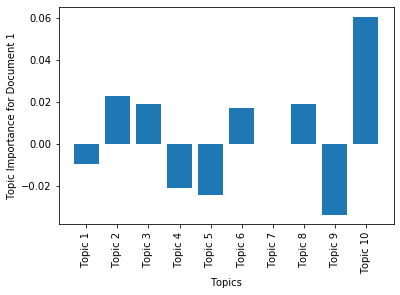

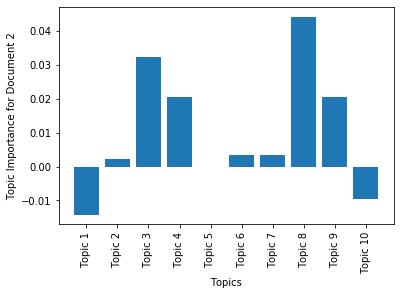

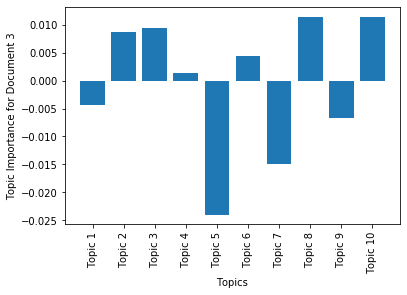

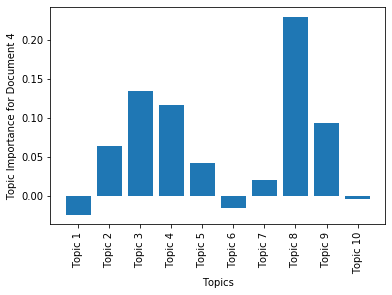

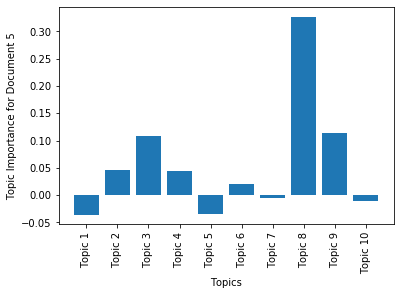

In [13]:
labels = []
for j in range(test_LSA.transform().shape[1]):
    labels.append('Topic ' + str(j + 1))

x = np.arange(len(labels))
    
for i in range(5):
    plt.bar(x, test_LSA.transform()[i])
    plt.xticks(x, labels, rotation = 'vertical')
    plt.xlabel('Topics')
    plt.ylabel('Topic Importance for Document ' + str(i + 1))
    plt.show()